### This is to study the relationship between phase in oscilation and performance


先经过100ms的pre-stimulaiton时间来让震荡稳定下来  
然后根据希尔伯特变换找到100ms后的第一个相位最低点的位置（-pi）  
从这个位置开始刺激10ms+测试  
全程1000ms  

In [1]:
# import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.signal import hilbert

from functions import Draw_Output, Draw_Conductance, Draw_RasterPlot, Draw_Voltage, Draw_Projection, show_mn, show_conn
from functions import  save_model, load_config_yaml, load_init
from functions import Generate_Vectors, Generate_RandomMatrix
from lowranksnn import LowRankSNN
plt.rcParams.update({'font.size': 30})  


In [2]:
# Read the configuration file
config = load_config_yaml('config_test_phase_sensitivity.yaml')
# config = load_config_yaml('confi_gamma_os_bias_only.yaml')
# config = load_config_yaml('config_test.yaml')

N_E = config['N_E']
N_I = config['N_I']
N = N_E + N_I
P_EE = config['P_EE']
P_EI = config['P_EI']
P_IE = config['P_IE']
P_II = config['P_II']
factor_mn = config['factor_mn'] # 组合成conn时乘在lowrank matrix上的常數
RS = config['RandomStrength'] # 组合成conn时乘在random matrix上的常數

taud_E = config['taud_E']
taud_I = config['taud_I']

eta_E = config['eta_E']
eta_I = config['eta_I']
delta_E = config['delta_E']
delta_I = config['delta_I']

mu = config['mu']
si = config['sigma']

si_rand = config['sigma_rand']
dt = config['dt'] #(ms/step)
T_pre = config['T_pre'] # length of time before sti (ms)
T_sti = config['T_sti'] # length of time for sti (ms)
T_after = config['T_after'] # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms

IS = config['InputStrength'] #Input Strength (maybe chage to norm in the future)

color_Go = config['color_Go']
color_Nogo = config['color_Nogo']

num_phase = config['num_phase']
trails = config['trails']


In [3]:
# Initialiazation
LRSNN = LowRankSNN(N_E=N_E,N_I=N_I,taud_E=taud_E,taud_I=taud_I,RS=RS)
# Go_NoGo Task
# Prepare the Low Rank Connectivity (Rank = 1), Stimuli and Readout Vector
m, n, Sti_nogo = Generate_Vectors(N, mu, si)
m[N_E:] = 0
n[N_E:] = 0
Sti_nogo[N_E:] = 0
Sti_go = n.clone()
W_out = m.clone()
W_rank1 = factor_mn*torch.ger(m.squeeze(), n.squeeze())
conn_rand = Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma = si_rand)


In [4]:
# Assemble the Network
LRSNN.add_lowrank(W_rank1, W_out)
LRSNN.add_random(conn_rand)
# # count the number of values outside the range of 0 and 1
# print('Number of values outside the range of 0 and 1: ', torch.sum(LRSNN.conn>1)+torch.sum(LRSNN.conn<0))
# # ratio of values outside the range of 0 and 1 to the total number of values
# print('Ratio of values outside the range of 0 and 1 to the total number of values: ', (torch.sum(LRSNN.conn>1)+torch.sum(LRSNN.conn<0))/(N_E+N_I)**2)
LRSNN.conn[LRSNN.conn>1] = 1
LRSNN.conn[LRSNN.conn<0] = 0

Low Rank connection and readout vector have been added.
Random connection has been added.


In [5]:
# 1st simulation: get the first zero phase time after 100 ms (use hilbert transform)

T = T_pre+T_sti+T_after # length of Period time (ms）

Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go
Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo
#

# bias current
bias = torch.zeros_like(Input_go)
bias[:N_E,:] = (eta_E+delta_E*torch.tan(torch.tensor(np.pi*(np.arange(1,N_E+1)/(N_E+1)-1/2)))).unsqueeze(1)
bias[N_E:,:] = (eta_I+delta_I*torch.tan(torch.tensor(np.pi*(np.arange(1,N_I+1)/(N_I+1)-1/2)))).unsqueeze(1)

#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)
bias = bias.to(device)

# Start Simulation
# Out_go, V_go, g_go, I_syn_go, spk_step_go, spk_ind_go = LRSNN(dt,bias)
# Out_nogo, V_nogo, g_nogo, I_syn_nogo, spk_step_nogo, spk_ind_nogo = LRSNN(dt,Input_nogo+bias)
# _, _, g_ref, _, _, _ = LRSNN(dt,bias)
Out_ref, V_ref, [g_ref,g_ref_EE,g_ref_EI,g_ref_IE,g_ref_II],[I_ref_syn,I_ref_syn_EE,I_ref_syn_EI,I_ref_syn_IE,I_ref_syn_II], spk_step_ref, spk_ind_ref, spk_ref, phase_ref = LRSNN(dt,bias)
# Out_ref, V_ref, [g_ref,g_ref_EE,g_ref_EI,g_ref_IE,g_ref_II],[I_ref_syn,I_ref_syn_EE,I_ref_syn_EI,I_ref_syn_IE,I_ref_syn_II], spk_step_ref, spk_ind_ref, spk_ref, phase_ref = LRSNN(dt,Input_go+bias)

# g_ref_EE = g_ref[1]
# g_ref_II = g_ref[-1]


Start Simulation
Simulation Finished


In [6]:
# load the values at T_pre
# to see whether the results are the same
# step_init = int(T_pre/dt)
# g_init = g_ref[:,step_init].clone().detach()
# g_init_EE = g_ref_EE[:,step_init].clone().detach()
# g_init_EI = g_ref_EI[:,step_init].clone().detach()
# g_init_IE = g_ref_IE[:,step_init].clone().detach()
# g_init_II = g_ref_II[:,step_init].clone().detach()
# V_init = V_ref[:,step_init].clone().detach()
# phase_init = phase_ref[:,step_init].clone().detach()
# I_syn_init = I_ref_syn[:,step_init].clone().detach()
# I_syn_init_EE = I_ref_syn_EE[:,step_init].clone().detach()
# I_syn_init_EI = I_ref_syn_EI[:,step_init].clone().detach()
# I_syn_init_IE = I_ref_syn_IE[:,step_init].clone().detach()
# I_syn_init_II = I_ref_syn_II[:,step_init].clone().detach()
# spk_init = spk_ref[:,step_init]
# LRSNN.load_init(g_init, g_init_EE, g_init_EI, g_init_IE, g_init_II, V_init, phase_init, I_syn_init, I_syn_init_EE, I_syn_init_EI, I_syn_init_IE, I_syn_init_II, spk_init)

LRSNN = load_init(LRSNN, T_pre, dt, g_ref, g_ref_EE, g_ref_EI, g_ref_IE, g_ref_II, V_ref, phase_ref, I_ref_syn, I_ref_syn_EE, I_ref_syn_EI, I_ref_syn_IE, I_ref_syn_II, spk_ref)

# Out, V, [g,g_EE,g_EI,g_IE,g_II],[I_syn,I_syn_EE,I_syn_EI,I_syn_IE,I_syn_II], spk_step, spk_ind, spk, phase = LRSNN(dt,bias[:,int(T_pre/dt):])


Initial values have been loaded.


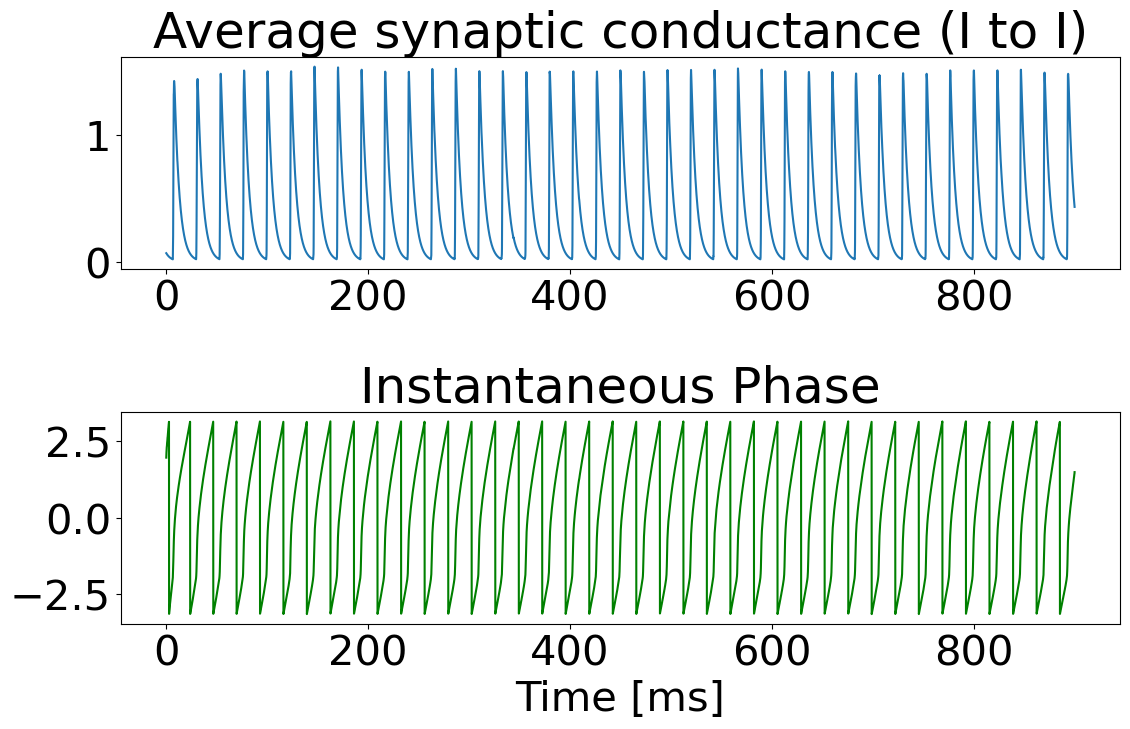

In [7]:

# do hilbert transform to get the phase of the conductance
# do hilbert transform to get the phase of the conductance
g_ref_EE_np = g_ref_EE.clone().cpu().detach().numpy()
g_ref_II_np = g_ref_II.clone().cpu().detach().numpy()

signal = np.mean(g_ref_II_np, axis=0)[int(T_pre/dt):]
# signal = np.mean(g_ref_II_np, axis=0)

# # filter out the high frequency noise in the signal
# from scipy.signal import butter, lfilter
# def butter_lowpass_filter(data, cutoff, fs, order=5):
#     nyquist = 0.5 * fs
#     normal_cutoff = cutoff / nyquist
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     y = lfilter(b, a, data)
#     return y
# signal = butter_lowpass_filter(signal, 100, 1000/dt, order=5) # cutoff frequency higher than 100 Hz

# centralize the signal
mean_signal = np.mean(signal)
signal = signal - mean_signal
analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)  # 振幅包络
instantaneous_phase = np.angle(analytic_signal)  # 相位信息
# 绘制波形及其相位信息
plt.figure(figsize=(12, 8))
t = np.array(range(len(signal)))*dt
# 原始信号
plt.subplot(2, 1, 1)
# plt.figure(figsize=(12, 8))
plt.plot(t, signal+mean_signal)
plt.title("Average synaptic conductance (I to I)")
# plt.xlabel("Time [ms]")
# plt.ylabel("Amplitude")
# plt.legend()

# # 振幅包络
# plt.subplot(3, 1, 2)
# plt.plot(t, amplitude_envelope, color='orange')
# plt.title("Amplitude Envelope (Magnitude of Analytic Signal)")

# 相位信息
plt.subplot(2, 1, 2)
# plt.figure(figsize=(12, 8))
plt.plot(t, instantaneous_phase, color='green')
plt.title("Instantaneous Phase")
plt.xlabel("Time [ms]")
# plt.ylabel("Phase [radians]")
# plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# find out the first minimum phase
# take phase_start as -pi, and phase_end as pi
flag = 1
for i in range(1,len(instantaneous_phase)-1):
    if flag == 1 and instantaneous_phase[i-1]>instantaneous_phase[i]<instantaneous_phase[i+1] and instantaneous_phase[i]< -3.13:
        phase_start = instantaneous_phase[i]
        phase_start_ind = i
        flag = 0
        continue
    if flag == 0 and instantaneous_phase[i-1]<instantaneous_phase[i]>instantaneous_phase[i+1] and instantaneous_phase[i]> 3.13 and (i-phase_start_ind)*dt>10:
        phase_end = instantaneous_phase[i]
        phase_end_ind = i
        flag = -1
if flag != -1:
    # if did not find the phase_end, return error message and jump to the next trail
    print('Error: did not find the phase_end (or phase_start) in the instantaneous_phase')
    # store the instantaneous_phase into a file
    # now = datetime.datetime.now()
    # np.save('./data_phase_to_reaction_times/instantaneous_phase'+now.strftime('%y%m%d%H%M%S')+'.npy', instantaneous_phase)
    # continue

phases_eff = np.linspace(phase_start, phase_end, num_phase)

def nearest_phase_ind(arr, phase_target):
    return np.argmin(np.abs(arr-phase_target))

phases_eff_ind = phase_start_ind + np.array([nearest_phase_ind(instantaneous_phase[phase_start_ind:phase_end_ind+1],phase_target) for phase_target in phases_eff])
phases_eff = instantaneous_phase[phases_eff_ind]

# phases_eff_ind += int(T_pre/dt)
phases_eff_times = phases_eff_ind*dt # the time of the effective phases after T_pre (ms)


In [9]:
#simulation: get the reaction time for different phases

#store the reaction time for different phases
reaction_times = []
Input_go_rec = []
Out_go_rec = []
Out_nogo_rec = []

T_pre_origin = T_pre
T_after_origin = T_after
for T_phase in phases_eff_times:
    T_pre = T_phase
    T_after = T_after_origin-T_phase # length of time after sti (ms) for the 2nd simulation
    # T = T_pre+T_sti+T_after # length of Period time (ms）
    T = T_pre+T_sti+T_after

    Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
    Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go
    Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
    Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo

    Input_go_rec.append(Input_go.tolist())

    # bias current
    bias = torch.zeros_like(Input_go)
    bias[:N_E,:] = (eta_E+delta_E*torch.tan(torch.tensor(np.pi*(np.arange(1,N_E+1)/(N_E+1)-1/2)))).unsqueeze(1)
    bias[N_E:,:] = (eta_I+delta_I*torch.tan(torch.tensor(np.pi*(np.arange(1,N_I+1)/(N_I+1)-1/2)))).unsqueeze(1)
 
    #将模型及相应属性移动到GPU
    device = torch.device('cuda:0')
    LRSNN = LRSNN.to(device)
    Input_go = Input_go.to(device)
    Input_nogo = Input_nogo.to(device)
    bias = bias.to(device)

    # Note: initial values has been loaded
    # Start Simulation
    Out_go, V_go, g_go, I_syn_go, spk_step_go, spk_ind_go,_,_ = LRSNN(dt,Input_go+bias)
    Out_nogo, V_nogo, g_nogo, I_syn_nogo, spk_step_nogo, spk_ind_nogo,_,_ = LRSNN(dt,Input_nogo+bias)

    Out_go_rec.append(Out_go.cpu().tolist())
    Out_nogo_rec.append(Out_nogo.cpu().tolist())

    # g_go_EE = g_go[1]
    # g_nogo_EE = g_nogo[1]

    # # define the reaction time as performance
    # # reaction time: 从施加刺激开始到输出不为0的时间（或者到go输出大于nogo输出的时间）
    # # calculate the time when the output of go exceed the output of nogo
    # difference = Out_go - Out_nogo
    # exceed_time = torch.nonzero(difference.squeeze()>0)[0].item()*dt
    # reaction_time = exceed_time-T_pre
    # reaction_times.append(reaction_time)
    # print('Phase: ', phases_eff[phases_eff_times==T_phase])
    # print('Reaction Time: ', reaction_time, 'ms')

    # # 处理绘图用的数据以使其能够在cpu上运行
    # Out_go = Out_go.cpu().numpy()
    # Out_nogo = Out_nogo.cpu().numpy()
    # Input_go = Input_go.cpu().numpy()
    # Input_nogo = Input_nogo.cpu().numpy()
    # g_go = [g.cpu().numpy() for g in g_go]
    # g_nogo = [g.cpu().numpy() for g in g_nogo]

    # # Draw Output
    # fig, ax = plt.subplots(figsize=(15,5))
    # Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
    # Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)
    # # save the figure
    # fig.savefig('./data_figs/Output_phase_'+str(T_phase)+'.png')
    
    # tag = ['g\_all','g\_EE','g\_EI','g\_IE','g\_II']
    # colors = ['#800080','#FF0000','#009999','#FFA500','#1C63A9']

    # # y_lim = [0,1.5]
    # y_lim = [0,0.1]
    # fig, ax = plt.subplots(figsize=(15,5))
    # Draw_Conductance(ax,g_go,colors,tag,dt,Input_go,ylim=y_lim,title="Average Synaptic Conductance for Go")
    # # save the figure
    # fig.savefig('./data_figs/con_go_phase_'+str(T_phase)+'.png')
    # fig, ax = plt.subplots(figsize=(15,5))
    # Draw_Conductance(ax,g_nogo,colors,tag,dt,Input_nogo,ylim=y_lim,title="Average Synaptic Conductance for NoGo")
    # # save the figure
    # fig.savefig('./data_figs/con_nogo_phase_'+str(T_phase)+'.png')

    # # Raster Plot
    # fig, ax = plt.subplots(figsize=(15,5))
    # Draw_RasterPlot(ax,spk_step_go, spk_ind_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
    # # save the figure
    # fig.savefig('./data_figs/rp_go_phase_'+str(T_phase)+'.png')
    # fig, ax = plt.subplots(figsize=(15,5))
    # Draw_RasterPlot(ax,spk_step_nogo,spk_ind_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
    # # save the figure
    # fig.savefig('./data_figs/rp_nogo_phase_'+str(T_phase)+'.png')

T_pre = T_pre_origin
T_after = T_after_origin

Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using loaded initial values
Simulation Finished
Start Simulation
Using lo

In [ ]:
Input_go_rec = np.array(Input_go_rec)
Out_go_rec = np.array(Out_go_rec)
Out_nogo_rec = np.array(Out_nogo_rec)

# save the data
import datetime
now = datetime.datetime.now()
# create a folder to store the data, name=now
import os
folder = f'./data_phase_sensitivity_{now.strftime("%y%m%d%H%M%S")}'
os.makedirs(folder)
np.save(folder+'/Input_go_rec'+'.npy', Input_go_rec)
np.save(folder+'/Out_go_rec'+'.npy', Out_go_rec)
np.save(folder+'/Out_nogo_rec'+'.npy', Out_nogo_rec)
np.save(folder+'/phases_eff'+'.npy', phases_eff)




In [38]:
# import csv
# import datetime
# now = datetime.datetime.now()
# filename = './data_phase_to_reaction_times/reaction_times_'+now.strftime('%y%m%d%H%M%S')+'.csv'
# with open(filename, mode='w') as file:
#     writer = csv.writer(file)
#     for i in range(len(phases_eff)):
#         writer.writerow([phases_eff[i], reaction_times[i]])

画结果图

In [39]:
# plot the reaction time for different phases using the csv file in ./data_phase_to_reaction_times
import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# phases = []
phases = 2*np.pi*np.linspace(0, 1, num_phase)-np.pi
reaction_times = []
folder_path = './data_phase_to_reaction_times/'
# folder_path = Path('./data_phase_to_reaction_times/')

for file in Path('./data_phase_to_reaction_times/').iterdir():
    print(file.name)
    phases_temp = []
    reaction_times_temp = []
    with open(folder_path+file.name, mode='r') as f:
        reader = csv.reader(f)
        for row in reader:
            phases_temp.append(float(row[0]))
            reaction_times_temp.append(float(row[1]))
    reaction_times.append(reaction_times_temp)
    # plt.figure(figsize=(15, 5))
    # plt.plot(phases_temp, reaction_times_temp, label=file.name)
    # plt.xlabel('Phase')
    # plt.ylabel('Reaction Time [ms]')
    # plt.title('Reaction Time for Different Phases')
    # plt.legend()
    # plt.show()




reaction_times_241118151214.csv
reaction_times_241118165357.csv
reaction_times_241118175039.csv
reaction_times_241118162510.csv
reaction_times_241118181842.csv
reaction_times_241118170830.csv
reaction_times_241118152647.csv
reaction_times_241118154128.csv
reaction_times_241118173641.csv
reaction_times_241118163941.csv
reaction_times_241118155612.csv
reaction_times_241118183240.csv
reaction_times_241118180437.csv
reaction_times_241118161045.csv
reaction_times_241118172234.csv


In [ ]:
# # Average and std of the reaction times for different phases
# reaction_times = np.array(reaction_times)
# reaction_times_mean = np.mean(reaction_times, axis=0)
# reaction_times_std = np.std(reaction_times, axis=0)

# # plot the average reaction time for different phases
# plt.figure(figsize=(15, 5))
# plt.errorbar(phases, reaction_times_mean, yerr=reaction_times_std, fmt='o')
# # set the xticks in the unit of pi
# plt.xticks(np.arange(-np.pi, np.pi+0.1, np.pi/2),['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$'])
# plt.xlabel('Phase')
# plt.ylabel('Reaction Time [ms]')
# plt.title('Average Reaction Time for Different Phases')
# plt.show()

